In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from PIL import Image
from time import gmtime, strftime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# !ls gdrive/My\ Drive/ACVPR/Data

In [0]:
base_path = "../Data/CK_CK+/CK+/"

In [0]:
neutralised_path = "NeutralisedImages/CK_CK+/CK+/" + 'cohn-kanade-images'
all_neutralisedImage_files = glob.glob(neutralised_path+'/**/*.png', recursive=True)

In [0]:
all_emotions = {0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 
                4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}

In [0]:
import copy

class Image():
    
    def __init__(self, image, landmarks, emotion, name):
        self.image = image
        self.original_image = copy.deepcopy(self.image)
        self.name = name
        self.emotion = emotion
        self.landmarks = landmarks
        self.neutralised_image = np.array([])
        self.hash = hash(self)
    
    def getEmotion(self):
        return self.emotion
    
    def getLandmarks(self):
        return self.landmarks
    
    def setNeutralisedImage(self, image):
        self.neutralised_image = image
        
    def getNeutralisedImage(self):
        return self.neutralised_image
        
    def getName(self):
        return self.name
        
    def getImage(self):
        return self.image
    
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getHash(self):

        return self.hash

In [0]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

In [0]:
def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)
    
def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2].astype(np.int32)), tuple(triangle_points_array[2:4].astype(np.int32)), tuple(triangle_points_array[4:6].astype(np.int32)))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    triangle_im = im
    triangle_mask = np.zeros_like(im)

    triangle_mask_fill_points = np.array([
            [pt1[0], pt1[1]],
            [pt2[0], pt2[1]],
            [pt3[0], pt3[1]]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
        
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
    return cropped_triangle

def cropByLandmarks(im,ld):
    landmarks = list(map(lambda x: tuple(x),ld))

    im_shape = im.shape
    
    rect = (0,0,im_shape[1],im_shape[0])
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks)
    
    triangles = subdiv.getTriangleList()
    cropped_image = np.zeros_like(im) 
    for triangle in triangles:
        triangle_image = getTriangleImage(im, triangle)      
        cropped_image = cv2.add(cropped_image, triangle_image)

    return cropped_image

In [0]:
# from tqdm import tqdm

# crop_imsize = 350
# subjects = []

# with tqdm(total=len(all_neutralisedImage_files), desc="Processing entries") as pbar:

#     for neutral_image_path in all_neutralisedImage_files[:]:

#         original_image_path = "../Data/" + "/".join(neutral_image_path.split("/")[1:])
#         landmark_path = base_path + "Landmarks/" + "/".join(neutral_image_path.split("/")[4:])[:-4] + '_landmarks.txt'
#         emotion_path = base_path + "Emotion/" + "/".join(neutral_image_path.split("/")[4:-1])
        
#         emotion_files = glob.glob(emotion_path+'/*.txt')

#         if len(emotion_files) < 1:
#             pbar.update(1)
#             continue

#         with open(emotion_files[0]) as emotion_file:
#             emotion = emotion_file.read()
#             emotion = all_emotions[(int(float(emotion)))]

#         landmarks = np.loadtxt(landmark_path)
        
#         original_image, resized_landmarks = detect_face(original_image_path, landmarks)  
#         original_image = cv2.resize(original_image,(crop_imsize, crop_imsize))
#         original_image = cropByLandmarks(original_image, resized_landmarks)

#         neutralised_image = cv2.imread(neutral_image_path) #Open Neutralised image
#         neutralised_image = cv2.cvtColor(neutralised_image, cv2.COLOR_BGR2GRAY)
# #         pairPlot(original_image, neutralised_image)
#         im_object = Image(original_image, landmarks, emotion, int((original_image_path.split("/")[-1])[:-4].split('_')[0][1:]))
#         im_object.setNeutralisedImage(neutralised_image)

#         subjects.append(im_object)
#         pbar.update(1)

## Half of the images do not have an emotion???!

In [0]:
# len(subjects)

# Create datasets for face recognition and exp recognition

In [11]:
!ls

gdrive	sample_data


In [0]:
# images_data = []

# for image in subjects:
#     images_data.append(np.array([image.getNeutralisedImage(), image.getImage(), image.getEmotion(), image.getName()]))

# images_df = pd.DataFrame(images_data, columns=['neutralised_image', 'original_image', 'original_emotion', 'name'])

In [0]:
# images_df.to_pickle('./joined_images_df.pkl')

In [0]:
images_df = pd.read_pickle('gdrive/My Drive/ACVPR/Data/joined_images_df.pkl')

In [0]:
## Add original images to dataset
augmented_images_df = pd.DataFrame(columns=np.append(images_df.columns.values, 'all_images'))

for index, image in images_df.iterrows():
    resized_scale = (160,160)
    resized_original = cv2.resize(image['original_image'], resized_scale) 
    resized_neutralised = cv2.resize(image['neutralised_image'], resized_scale) 

    # original format, but resized
    augmented_images_df = augmented_images_df.append({
        'all_images': resized_original, 
        'neutralised_image': resized_neutralised , 
        'original_image': resized_original, 
        'original_emotion': image['original_emotion'], 
        'name': image['name']}, 
        ignore_index=True)
    
    # swapped format and resized
    augmented_images_df = augmented_images_df.append({
        'all_images': resized_neutralised, 
        'neutralised_image': resized_neutralised , 
        'original_image': resized_original, 
        'original_emotion': image['original_emotion'], 
        'name': image['name']}, 
        ignore_index=True)

In [0]:
augmented_images_df = augmented_images_df.sample(frac=1)

In [17]:
print(len(images_df), len(augmented_images_df))
augmented_images_df.head(3)

5876 11752


,neutralised_image,original_image,original_emotion,name,all_images
5363,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",happy,115,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
10585,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",contempt,154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4029,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",fear,502,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [0]:
images_df['original_image'].to_numpy()#, augmented_images_df['neutralised_image'] )

In [0]:
num_samples = 5000
augmented_images_df = augmented_images_df.iloc[:num_samples]

In [19]:
## Saving some memory by deleting images_df variable
%reset_selective "^images_df$"

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [20]:
X_rec_origin, y_rec_origin = augmented_images_df[['all_images','original_image', 'neutralised_image']], augmented_images_df['name']

X_rec_origin_train, X_rec_origin_test, y_rec_origin_train, y_rec_origin_test = train_test_split(X_rec_origin, y_rec_origin, test_size=0.33, random_state=42)
X_rec_origin_train.reset_index(drop=True, inplace=True), X_rec_origin_test.reset_index(drop=True, inplace=True)
y_rec_origin_train.reset_index(drop=True, inplace=True), y_rec_origin_test.reset_index(drop=True, inplace=True)
X_rec_origin_train.shape, X_rec_origin_test.shape, y_rec_origin_train.shape, y_rec_origin_test.shape

((3350, 3), (1650, 3), (3350,), (1650,))

In [0]:
len(set(y_rec_origin_train.to_numpy()))

118

<Figure size 432x288 with 0 Axes>

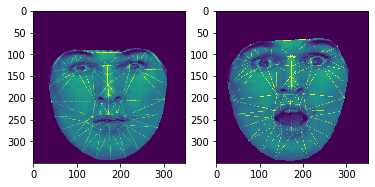

In [0]:
pairPlot(images_df[['neutralised_image']].iloc[205].to_numpy()[0], images_df[['original_image']].iloc[205].to_numpy()[0])

array([ 68,  10,  68, ..., 115,  62,  56], dtype=int32)

# Fisher Face

In [0]:
fishface = cv2.face.FisherFaceRecognizer_create() #Initialize fisher face classifier
fishface.train(X_rec_origin_train['neutralised_image'].to_numpy(), y_rec_origin_train.to_numpy(dtype=np.int32))

In [0]:
correct = 0
incorrect = 0
confidences_original = []
confidences_neutralised = []
for cnt, image in enumerate(X_rec_origin_test['all_images']):
    pred, conf = fishface.predict(image)
    
    if np.array_equal(image , X_rec_origin_test['original_image'][cnt]):
      confidences_original.append(conf)
    elif np.array_equal(image , X_rec_origin_test['neutralised_image'][cnt]):
      confidences_neutralised.append(conf)
    else:
      pass #should never happen
    
    if pred == np.array(y_rec_origin_test)[cnt]:
        correct += 1
    else:
        incorrect += 1

    if cnt % 500 == 0:
        print("[{}] {}% is done".format(strftime("%Y-%m-%d %H:%M:%S", gmtime()), str(cnt/len(X_rec_origin_test) * 100)))
print('Emotion Acc: ', (100*correct)/(correct + incorrect))

plt.hist(confidences_original, density=True, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(confidences_neutralised, density=True, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('Eigen Face recognition, accuracy: {}'.format( (100*correct)/(correct + incorrect)))
plt.savefig('EigenFacerecognition.png')
plt.legend()

[2019-12-10 19:20:06] 0.0% is done
[2019-12-10 19:20:08] 30.303030303030305% is done
[2019-12-10 19:20:10] 60.60606060606061% is done
[2019-12-10 19:20:13] 90.9090909090909% is done
Emotion Acc:  99.81818181818181
[2019-12-10 19:20:13] 0.0% is done
[2019-12-10 19:20:16] 30.303030303030305% is done
[2019-12-10 19:20:18] 60.60606060606061% is done
[2019-12-10 19:20:21] 90.9090909090909% is done
Emotionless Acc:  99.33333333333333


In [0]:
print(fishface.predict(X_rec_origin_test['original_image'][10]), y_rec_origin_test[10], 
      fishface.predict(X_rec_origin_test['neutralised_image'][10]), y_rec_origin_test[10])

(90, 4577.445127442707) 55 (55, 134.1073278241769) 55


# Eigen Face

In [0]:
eigenface = cv2.face.EigenFaceRecognizer_create()
eigenface.train(X_rec_origin_train['neutralised_image'].to_numpy(), y_rec_origin_train.to_numpy(dtype=np.int32))

In [0]:
correct = 0
incorrect = 0
confidences_original = []
confidences_neutralised = []
for cnt, image in enumerate(X_rec_origin_test['all_images']):
    pred, conf = eigenface.predict(image)
    
    if np.array_equal(image , X_rec_origin_test['original_image'][cnt]):
      confidences_original.append(conf)
    elif np.array_equal(image , X_rec_origin_test['neutralised_image'][cnt]):
      confidences_neutralised.append(conf)
    else:
      pass #should never happen
    
    if pred == np.array(y_rec_origin_test)[cnt]:
        correct += 1
    else:
        incorrect += 1

    if cnt % 500 == 0:
        print("[{}] {}% is done".format(strftime("%Y-%m-%d %H:%M:%S", gmtime()), str(cnt/len(X_rec_origin_test) * 100)))
print('Emotion Acc: ', (100*correct)/(correct + incorrect))

plt.hist(confidences_original, density=True, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(confidences_neutralised, density=True, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('Eigen Face recognition, accuracy: {}'.format( (100*correct)/(correct + incorrect)))
plt.savefig('EigenFacerecognition.png')
plt.legend()

In [0]:
print(eigenface.predict(X_rec_origin_test['original_image'][10]), y_rec_origin_test[10], 
      eigenface.predict(X_rec_origin_test['neutralised_image'][10]), y_rec_origin_test[10])

(90, 12562.90669242794) 55 (55, 1924.4147285173933) 55


# LBHP 

In [0]:
lbph_face = cv2.face.LBPHFaceRecognizer_create()
lbph_face.train(X_rec_origin_train['all_images'], y_rec_origin_train.to_numpy(dtype=np.int32))

[2019-12-13 11:17:43] 0.0% is done
[2019-12-13 11:19:33] 30.303030303030305% is done
[2019-12-13 11:21:23] 60.60606060606061% is done
[2019-12-13 11:23:13] 90.9090909090909% is done
Emotion Acc:  99.21212121212122


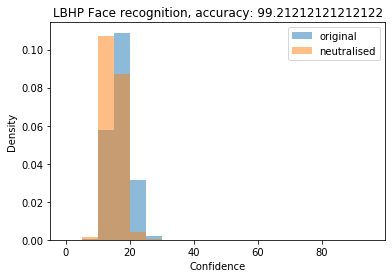

In [0]:
correct = 0
incorrect = 0
confidences_original = []
confidences_neutralised = []
for cnt, image in enumerate(X_rec_origin_test['all_images']):
    pred, conf = lbph_face.predict(image)
    
    if np.array_equal(image , X_rec_origin_test['original_image'][cnt]):
      confidences_original.append(conf)
    elif np.array_equal(image , X_rec_origin_test['neutralised_image'][cnt]):
      confidences_neutralised.append(conf)
    else:
      pass #should never happen
    
    if pred == np.array(y_rec_origin_test)[cnt]:
        correct += 1
    else:
        incorrect += 1

    if cnt % 500 == 0:
        print("[{}] {}% is done".format(strftime("%Y-%m-%d %H:%M:%S", gmtime()), str(cnt/len(X_rec_origin_test) * 100)))
print('Emotion Acc: ', (100*correct)/(correct + incorrect))

plt.hist(confidences_original, density=True, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(confidences_neutralised, density=True, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('LBHP Face recognition, accuracy: {}'.format( (100*correct)/(correct + incorrect)))
plt.savefig('LBHPFacerecognition.png')
plt.legend()

In [0]:
print(lbph_face.predict(X_rec_origin_test['original_image'][10]), y_rec_origin_test[10], 
      lbph_face.predict(X_rec_origin_test['neutralised_image'][10]), y_rec_origin_test[10])

(73, 4.596833089278591) 73 (73, 4.734876506819591) 73


<Figure size 432x288 with 0 Axes>

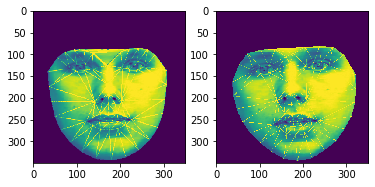

In [0]:
im_indx = 355
pairPlot(images_df.iloc[im_indx]['neutralised_image'],images_df.iloc[im_indx]['original_image'])

In [0]:
print(lbph_face.predict(X_rec_origin_test['original_image'][im_indx]), y_rec_origin_test[im_indx], 
      lbph_face.predict(X_rec_origin_test['neutralised_image'][im_indx]), y_rec_origin_test[im_indx])

(75, 4.857063873657447) 75 (75, 14.4775203870867) 75
